# Nearest Earth Object Classification

### By Michael D'Arcy-Evans and Isabel Tilles

## Introduction:
The solar system is a dangerous place. One fear that scientists have is that we will be harmed an objects as it hurtles towards us from space. We spot objects like these coming towards Earth all the time, but how do we know if they are going to devastate us or simply provide a good comet show? We are seeking to solve that issue by creating a reliable classifier to determine whether or not a Near Earth Object (NEO) is hazardous.  
We got our data from the [Nearest Earth Objects Dataset (1910-2024)](\"https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024\"). Based on these instances, we hope to predict whether or not other unseen instances of NEOs will be classified as `is_hazardous`.  
#TODO: What classifier performed the best?

## Imports for Analysis

In [11]:
# some useful mysklearn package import statements and reloads
import importlib


import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import pickle


## Data Analysis

Before cleaning the dataset, this is what it looks like:

This dataset has 338171 instances and 9 attributes
Dataset attribute breakdown:  neo_id is of type <class 'float'> 
 name is of type <class 'str'> 
 absolute_magnitude is of type <class 'float'> 
 estimated_diameter_min is of type <class 'float'> 
 estimated_diameter_max is of type <class 'float'> 
 orbiting_body is of type <class 'str'> 
 relative_velocity is of type <class 'float'> 
 miss_distance is of type <class 'float'> 
 is_hazardous is of type <class 'str'> .
The attribute we are trying to predict is is_hazardous. It can be 2 different classifications: {'True', 'False'}.

There are 295009 instances classified as False
There are 43162 instances classified as True


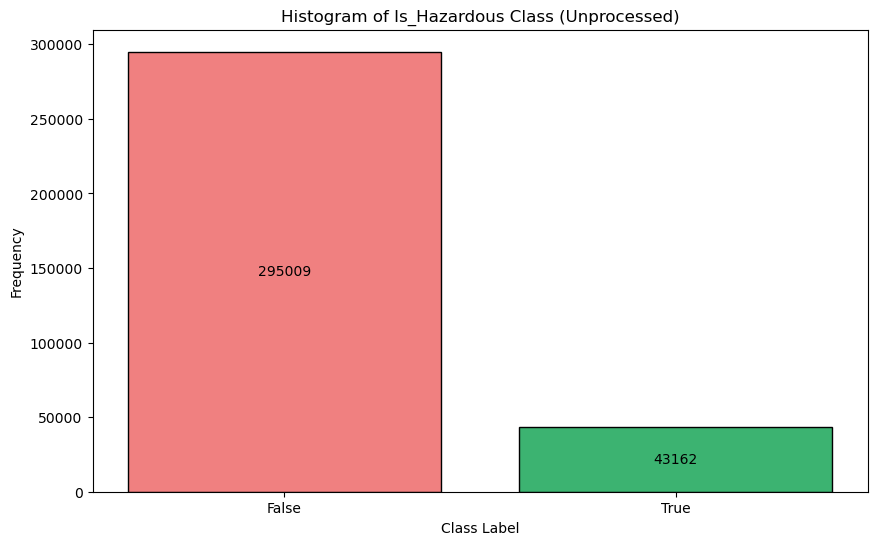

In [12]:
labels = ["True","False"]
space_table = MyPyTable().load_from_file('input_data/space.csv')

space_table.remove_rows_with_missing_values()
myutils.print_dataset_info(space_table)

space_dict = myutils.count_label_occurrences(space_table.get_column("is_hazardous"))
for value in sorted(space_dict.keys()):
    print(f"There are {space_dict[value]} instances classified as {value}")
    pass
myutils.plot_bar_chart(space_dict,"Unprocessed")

After cleaning the data to keep 1,000 instances of each classification, it looks like this:

This dataset has 2000 instances and 5 attributes
Dataset attribute breakdown:  min_labels is of type <class 'int'> 
 max_labels is of type <class 'int'> 
 velocity_labels is of type <class 'int'> 
 miss_labels is of type <class 'int'> 
 is_hazardous is of type <class 'str'> .
The attribute we are trying to predict is is_hazardous. It can be 2 different classifications: {'True', 'False'}.



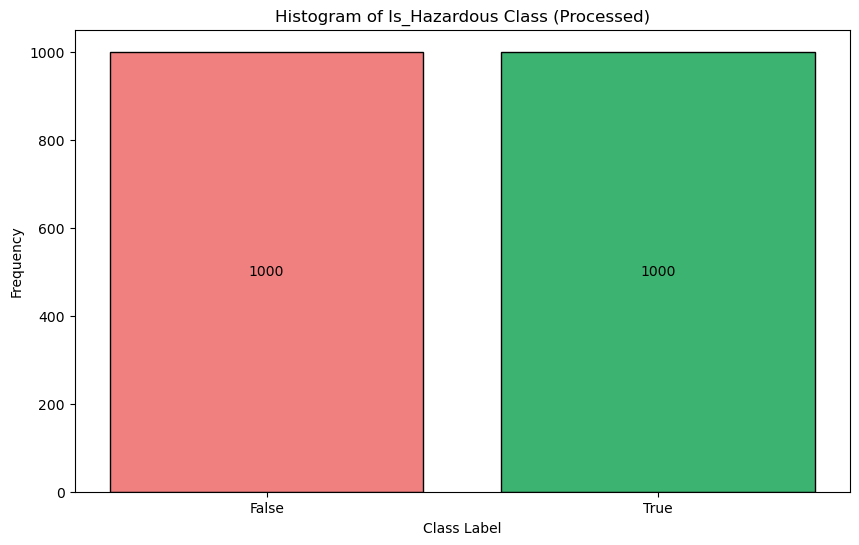

In [13]:
discretized_label_dict = myutils.preprocess_table(space_table)
y_true = space_table.get_column(space_table.column_names.index("is_hazardous"))  
X_train = [row[:space_table.column_names.index("is_hazardous")] + row[space_table.column_names.index("is_hazardous") + 1:] for row in space_table.data]
clean_data = [value + [y_true[index]] for index, value in enumerate(X_train)]
clean_space_table = MyPyTable(column_names=(list(discretized_label_dict.keys()) + ["is_hazardous"]), data = clean_data)

myutils.print_dataset_info(clean_space_table)

space_dict_processed = myutils.count_label_occurrences(space_table.get_column("is_hazardous"))
myutils.plot_bar_chart(space_dict_processed,"Processed")

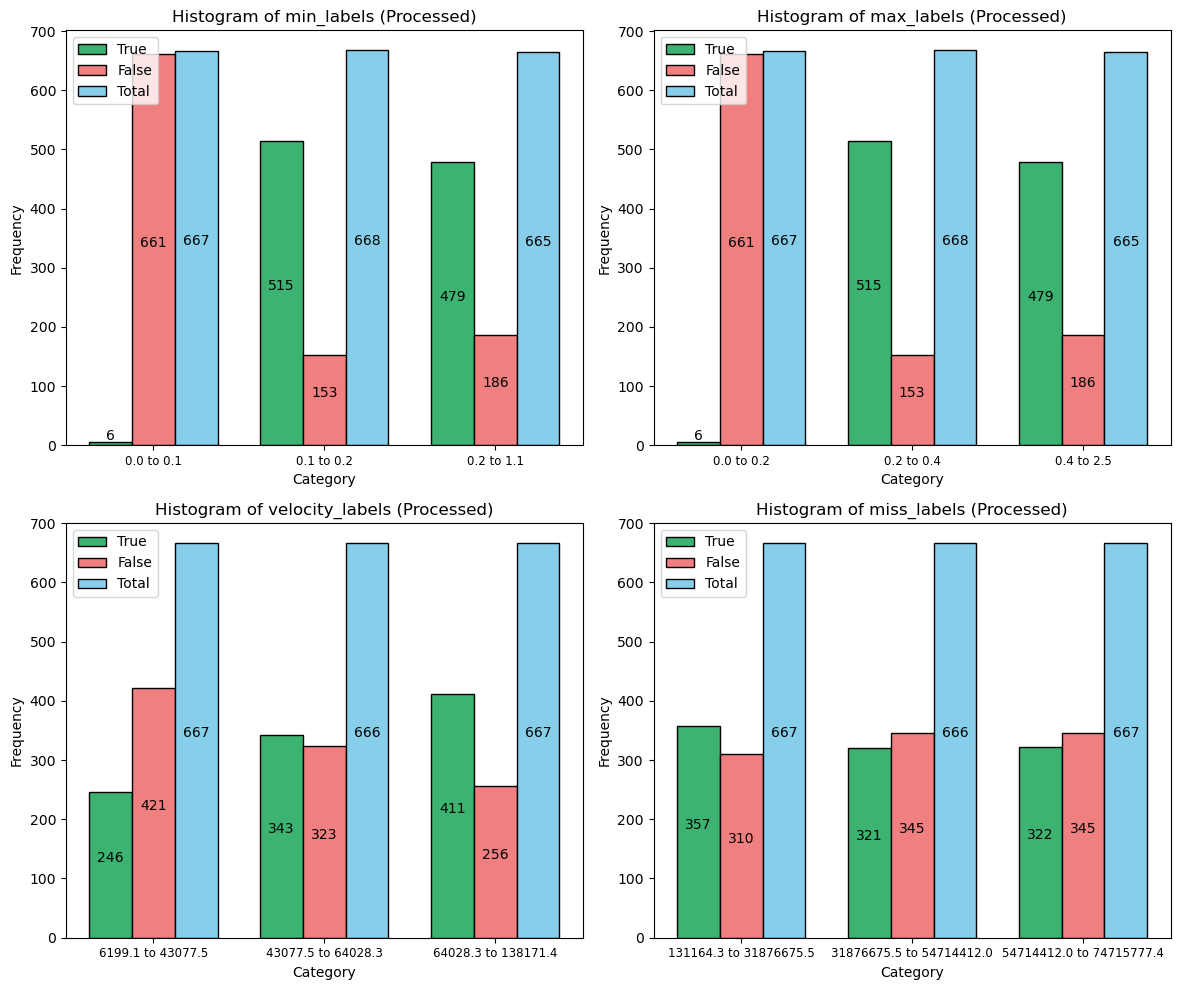

In [14]:
myutils.plot_multi_hist(discretized_label_dict,space_table.data)

## Classification Results
We chose to classify our results using Decision Tree, K-Nearest Neighbors, and Random Forest classifiers. The Decision Tree and K-Nearest Neighbors use stratified k-fold cross validation with 10 folds to generate their results. The Random Forest uses stratified cross-fold validation to split the data set into thirds. 1/3 becomes the test set to evaluate performance while 2/3 becomes the remainder set to be used to fit the trees in the forest. The Random Forest is homogenous, made up only of Decision Trees.  

We evaluated the classifiers on Recall primarily, since we want to ensure that people will know when a hazardous object is hurtling towards Earth. False positives could be expensive, but false negatives will be fatal. For cases where the Recall was really high, we also analyzed the Precision and Accuracy to make sure that the classifier didn't just predict Hazardous for every case.

### Decision Tree Classifier:
The Decision Tree classifier uses the TDIDT algorithm to build a tree. It splits on the attributes that will result in the smallest entropy. 

In [15]:
tree_classifier = MyDecisionTreeClassifier()
y_pred = myevaluation.cross_val_predict(tree_classifier,X_train,y_true,10)
print("\n", myevaluation.pseudo_classification_report(y_true,y_pred,labels))
 
header = space_table.column_names

tree_classifier.visualize_tree(
    "space_tree.dot", "space_tree", attribute_names=header
)


 Decision Tree Classifier: Accuracy = 0.83, Error Rate = 0.17, Precision = 0.7457, Recall = 0.9940, F1 Score = 0.8521
╒═════════════════╤════════╤═════════╕
│ Is Hazardous:   │   True │   False │
╞═════════════════╪════════╪═════════╡
│ True            │    994 │       6 │
├─────────────────┼────────┼─────────┤
│ False           │    339 │     661 │
╘═════════════════╧════════╧═════════╛


There was very high recall for this classifier, which was a positive. However, 1/3 of the non-hazardous instances would be classified as hazardous, meaning this would generate a substantial amount of false alarms. 

### kNN Classifier
The kNN classifier gets the k nearest neighbors of an instance and uses that to make a prediction about what the instance will be classified as. We chose to use 6 neighbors in this instance. 

In [16]:
knn_classifier = MyKNeighborsClassifier(6)
y_pred = myevaluation.cross_val_predict(knn_classifier,X_train,y_true,10)
print("\n", myevaluation.pseudo_classification_report(y_true,y_pred,labels))


 Decision Tree Classifier: Accuracy = 0.79, Error Rate = 0.21, Precision = 0.7642, Recall = 0.8330, F1 Score = 0.7971
╒═════════════════╤════════╤═════════╕
│ Is Hazardous:   │   True │   False │
╞═════════════════╪════════╪═════════╡
│ True            │    833 │     167 │
├─────────────────┼────────┼─────────┤
│ False           │    257 │     743 │
╘═════════════════╧════════╧═════════╛


The recall was lower for the kNN classifier than it was for the Decision Tree, so it is unlikely we would choose this classifier in our final steps. However, it does do a better job categorizing False instances as False, leading to less false alarms. If we were deploying a classifier to make predictions for an agency that wanted to focus on saving money more than they wanted to focus on disaster prevention, this could be a good mdoel for them.

### Random Forest Classifier:
Our Random Forest classifier generates N Decision Trees, then chooses the best M trees, "best" being measured by highest Recall. Then it takes the majority vote of the best classifiers and makes a prediction based off of that. For this dataset, we noticed that the Random Forest classifier performed the same regardless of if N = 60 or N = 5000 as long as M was close to 10% of N. For this reason, we chose to use N = 60 so that it would reduce strain on computers that are running this program and be more time efficient as well.

In [17]:
X = [row[:-1] for row in clean_space_table.data]
y = clean_space_table.get_column("is_hazardous")
forest = MyRandomForestClassifier(N = 60, M = 1, F = 2)
X_train, y_train, X_test, y_test = myutils.stratify_train_test_split(X, y, forest.M, 0)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print("\n", myevaluation.pseudo_classification_report(y_test, y_pred, labels, classifier_name="Random Forest"))

header = header[:-1]
myutils.save_pickle(header, forest.classifiers[0].tree)
infile = open("pickled_example.p", "rb")
header, tree = pickle.load(infile)
print(header)
print(tree)


 Random Forest Classifier: Accuracy = 0.83, Error Rate = 0.17, Precision = 0.7636, Recall = 0.9671, F1 Score = 0.8534
╒═════════════════╤════════╤═════════╕
│ Is Hazardous:   │   True │   False │
╞═════════════════╪════════╪═════════╡
│ True            │    323 │      11 │
├─────────────────┼────────┼─────────┤
│ False           │    100 │     234 │
╘═════════════════╧════════╧═════════╛
['estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']
['Attribute', 'att2', ['Value', 0, ['Attribute', 'att1', ['Value', 0, ['Attribute', 'att3', ['Value', 0, ['Leaf', 'False', 123, 227]], ['Value', 1, ['Leaf', 'False', 69, 227]], ['Value', 2, ['Leaf', 'False', 35, 227]]]], ['Value', 1, ['Attribute', 'att3', ['Value', 0, ['Leaf', 'True', 53, 136]], ['Value', 1, ['Leaf', 'True', 40, 136]], ['Value', 2, ['Leaf', 'True', 43, 136]]]], ['Value', 2, ['Attribute', 'att3', ['Value', 0, ['Leaf', 'True', 41, 116]], ['Value', 1, ['Leaf', 'False', 39, 116]], ['Value', 2, ['Lea

The Recall was slightly lower than the Decision Tree, but the scores were extremely close. We looked at the F1 and Accuracy scores as well due to the virtual tie. These were also very close, with the Random Forest barely beating out the Decision Tree.   
### Best Classifier: Random Forest
We ended up choosing the Random Forest classifier to use for the rest of our classification. We eliminiated the kNN classifier from contention immediately because it had much lower recall, F1, and accuracy scores than the other classifiers. Both the Random Forest and Decision Tree classifiers had really good Recall, but the Random Forest classifier is more well rounded, as is shown by its Accuracy and F1 scores.

In [18]:
# Example of a tree from the random forest - # TODO: delete
['Attribute', 'att2',     
    ['Value', 0,         
        ['Attribute', 'att1',             
            ['Value', 0,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'False', 123, 227]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'False', 69, 227]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'False', 35, 227]
                    ]
                ]
            ], 
            ['Value', 1,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'True', 53, 136]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'True', 40, 136]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'True', 43, 136]
                    ]
                ]
            ], 
            ['Value', 2,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'True', 41, 116]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'False', 39, 116]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'True', 36, 116]
                    ]
                ]
            ]
        ]
    ], 
    ['Value', 1,         
        ['Attribute', 'att1',             
            ['Value', 0, 
                ['Leaf', 'False', 138, 440]
            ], 
            ['Value', 1,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'True', 53, 147]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'True', 51, 147]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'True', 43, 147]
                    ]
                ]
            ], 
            ['Value', 2,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'True', 50, 155]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'True', 60, 155]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'True', 45, 155]
                    ]
                ]
            ]
        ]
    ], 
    ['Value', 2,         
        ['Attribute', 'att1',             
            ['Value', 0,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'False', 6, 79]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'False', 23, 79]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'False', 50, 79]
                    ]
                ]
            ], 
            ['Value', 1,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'True', 50, 147]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'True', 56, 147]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'True', 41, 147]
                    ]
                ]
            ], 
            ['Value', 2,                 
                ['Attribute', 'att3',                     
                    ['Value', 0, 
                        ['Leaf', 'True', 47, 187]
                    ], 
                    ['Value', 1, 
                        ['Leaf', 'True', 73, 187]
                    ], 
                    ['Value', 2, 
                        ['Leaf', 'True', 67, 187]
                    ]
                ]
            ]
        ]
    ]
]
print(" ")